In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from pennylane import AngleEmbedding, StronglyEntanglingLayers
import pennylane as qml
import os
import tensorflow as tf

2024-01-06 10:29:55.505325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 10:29:55.505398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 10:29:55.506069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 10:29:55.510076: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 10:29:56.111251: W tensorflow/compiler/tf2

In [2]:
num_qubits = 2

In [3]:
X, y = datasets.make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)

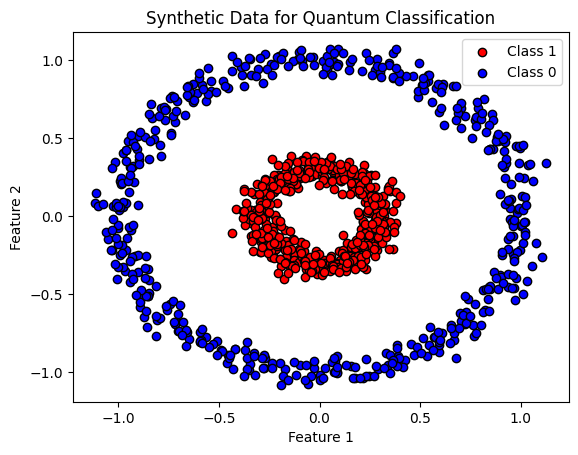

In [4]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', marker='o', edgecolors='k', label="Class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='b', marker='o', edgecolors='k', label="Class 0")
plt.title("Synthetic Data for Quantum Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [5]:
def quantum_circuit(W):
    qml.CNOT(wires=[1, 0])

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)

    qml.CNOT(wires=[0, 1])

In [6]:
def preprocessing(x):
    qml.AngleEmbedding(x, wires=[0, 1])

In [7]:
device = qml.device("default.qubit.tf", wires=2)

@qml.qnode(device, interface="tf")
def layer(weights, inputs):
    AngleEmbedding(inputs, wires=range(num_qubits))
    StronglyEntanglingLayers(weights, wires=range(num_qubits))

    #for weight in weights:
    #    quantum_circuit(weight)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

2024-01-06 10:29:56.940955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 10:29:56.961042: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 10:29:56.961100: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 10:29:56.963933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 10:29:56.963980: I external/local_xla/xla/stream_executor

In [8]:
num_layers = 1
epochs = 30

In [9]:
qlayer = qml.qnn.KerasLayer(layer, {"weights": (num_layers, num_qubits, 3)}, output_dim=num_qubits)
qlayer.trainable = True

In [10]:
preprocessing_ = tf.keras.layers.Dense(2, name="preprocessing", activation=None)
conplex_to_float = tf.keras.layers.Lambda(lambda x: tf.math.real(x), tf.float32)
classical_output = tf.keras.layers.Dense(2, activation="softmax")

In [11]:
model = tf.keras.models.Sequential([qlayer, classical_output])

In [12]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
model.compile(optimizer, loss=loss_fn, metrics=metrics)

In [14]:
fitting = model.fit(X, y, epochs=epochs, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/30


2024-01-06 10:29:59.519812: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/25 [>.............................] - ETA: 32s - loss: 1.0547 - sparse_categorical_accuracy: 0.4688WARNING:tensorflow:You are casting an input of type complex128 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


2024-01-06 10:30:00.570310: I external/local_xla/xla/service/service.cc:168] XLA service 0x15f40710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-06 10:30:00.570343: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-01-06 10:30:00.583782: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1704533400.621719    7724 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 3s 76ms/step - loss: 0.9060 - sparse_categorical_accuracy: 0.4512 - val_loss: 0.7864 - val_sparse_categorical_accuracy: 0.2950
Epoch 2/30
25/25 [==============================] - 2s 73ms/step - loss: 0.7643 - sparse_categorical_accuracy: 0.3413 - val_loss: 0.7541 - val_sparse_categorical_accuracy: 0.4950
Epoch 3/30
25/25 [==============================] - 2s 76ms/step - loss: 0.7445 - sparse_categorical_accuracy: 0.5013 - val_loss: 0.7369 - val_sparse_categorical_accuracy: 0.4950
Epoch 4/30
25/25 [==============================] - 2s 77ms/step - loss: 0.7276 - sparse_categorical_accuracy: 0.5013 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.4950
Epoch 5/30
25/25 [==============================] - 2s 78ms/step - loss: 0.7130 - sparse_categorical_accuracy: 0.5013 - val_loss: 0.7057 - val_sparse_categorical_accuracy: 0.4950
Epoch 6/30
25/25 [==============================] - 2s 76ms/step - loss: 0.6987 - sparse_categorical_accuracy: 0.501

In [15]:
model.evaluate(X, y, batch_size=8)

125/125 [==============================] - 5s 37ms/step - loss: 0.4442 - sparse_categorical_accuracy: 1.0000


[0.4442446529865265, 1.0]

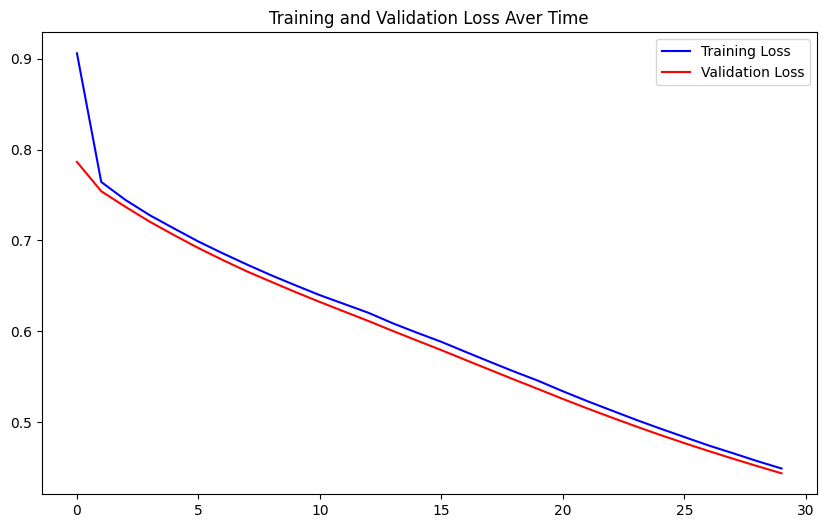

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(fitting.history['loss']), "-b", label="Training Loss")
plt.plot(np.array(fitting.history['val_loss']), "-r", label="Validation Loss")
plt.title("Training and Validation Loss Aver Time")
plt.legend()
plt.show()

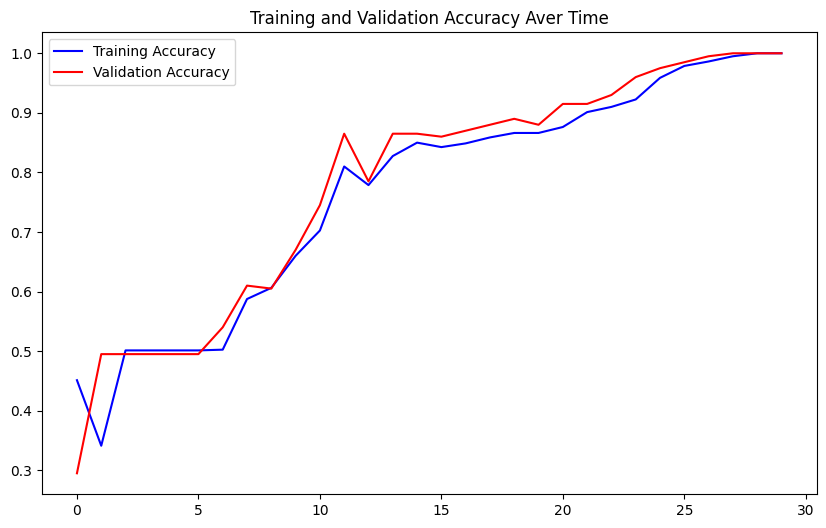

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(fitting.history['sparse_categorical_accuracy']), "-b", label="Training Accuracy")
plt.plot(np.array(fitting.history['val_sparse_categorical_accuracy']), "-r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy Aver Time")
plt.legend()
plt.show()